In [11]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("/content/loan_data.csv")

# Target interpretation:
# loan_paid_back = 1  -> loan fully repaid (non-default)
# loan_paid_back = 0  -> loan not repaid (default)
# 1) Basic counts
print("Target variable: loan_paid_back (1 = repaid, 0 = default)\n")
print("Counts:")
print(df["loan_paid_back"].value_counts())
print("\nProportions:")
print(df["loan_paid_back"].value_counts(normalize=True))

# 2) Simple summary stats grouped by target (optional but useful)
print("\nAverage numeric features by target (0 = default, 1 = repaid):")
numeric_cols = ["annual_income", "debt_to_income_ratio", "credit_score",
                "loan_amount", "interest_rate"]
print(df.groupby("loan_paid_back")[numeric_cols].mean())


Target variable: loan_paid_back (1 = repaid, 0 = default)

Counts:
loan_paid_back
1    214068
0     54046
Name: count, dtype: int64

Proportions:
loan_paid_back
1    0.798422
0    0.201578
Name: proportion, dtype: float64

Average numeric features by target (0 = default, 1 = repaid):
                annual_income  debt_to_income_ratio  credit_score  \
loan_paid_back                                                      
0                47897.127248              0.166675    654.813918   
1                48281.049653              0.109172    687.400480   

                 loan_amount  interest_rate  
loan_paid_back                               
0               15109.270990      12.887752  
1               15008.588604      12.223771  


In [8]:
# Drop id (unique identifier, not useful for prediction)
df = df.drop(columns=["id"])

# Separate features and target
X = df.drop(columns=["loan_paid_back"])
y = df["loan_paid_back"]

# Identify column types based on your file
numeric_features = [
    "annual_income",
    "debt_to_income_ratio",
    "credit_score",
    "loan_amount",
    "interest_rate",
]

categorical_features = [
    "gender",
    "marital_status",
    "education_level",
    "employment_status",
    "loan_purpose",
    "grade_subgrade",
]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Numerical pipeline: median imputation + scaling
numeric_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

# Categorical pipeline: most_frequent imputation + One-Hot encoding
categorical_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Full preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features),
    ]
)


Overall AUC: 0.9162


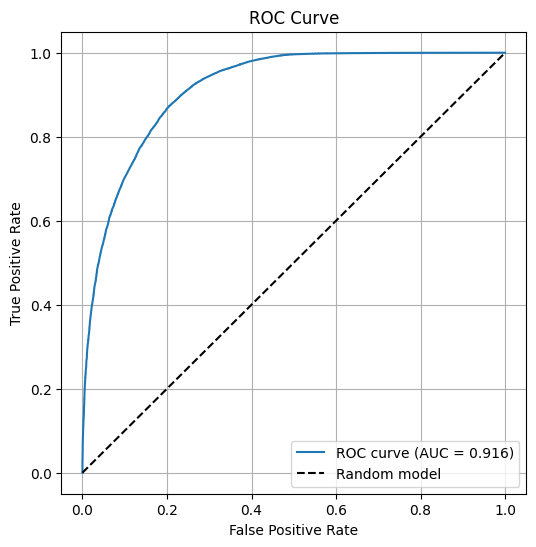

In [9]:
# Full pipeline with Gradient Boosting model
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", GradientBoostingClassifier(
            random_state=42
        )),
    ]
)

# Fit model
model.fit(X_train, y_train)

# Predict probabilities (probability of loan_paid_back = 1)
y_proba = model.predict_proba(X_test)[:, 1]

# 1) AUC value
overall_auc = roc_auc_score(y_test, y_proba)
print(f"Overall AUC: {overall_auc:.4f}")

# 2) ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# 3) Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {overall_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Optionally choose a threshold for classification decisions
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)


In [10]:
# Build a test dataframe with original subgroup columns and predictions
X_test_copy = X_test.copy()
X_test_copy["loan_paid_back"] = y_test.values
X_test_copy["proba"] = y_proba
X_test_copy["pred"] = y_pred

def auc_by_group(df_group, group_col):
    """
    Compute AUC per subgroup of group_col.
    Returns dict: subgroup -> AUC (NaN when only one class present).
    """
    results = {}
    for val in df_group[group_col].dropna().unique():
        sub = df_group[df_group[group_col] == val]
        # Need both classes to compute AUC
        if sub["loan_paid_back"].nunique() > 1:
            results[val] = roc_auc_score(sub["loan_paid_back"], sub["proba"])
        else:
            results[val] = np.nan
    return results

# AUC by education_level
edu_auc = auc_by_group(X_test_copy, "education_level")
print("\nAUC by education_level:")
for edu, auc_val in sorted(edu_auc.items(), key=lambda x: (np.nan_to_num(x[1], nan=-1))):
    print(f"{edu}: {auc_val:.4f}" if not np.isnan(auc_val) else f"{edu}: AUC not defined (single class)")

# AUC by loan_purpose (all purposes)
purpose_auc = auc_by_group(X_test_copy, "loan_purpose")

# Sort purposes by AUC, ignoring NaN
valid_purposes = [(p, a) for p, a in purpose_auc.items() if not np.isnan(a)]
valid_purposes_sorted = sorted(valid_purposes, key=lambda x: x[1])

print("\nAUC by loan_purpose (all):")
for purpose, auc_val in valid_purposes_sorted:
    print(f"{purpose}: {auc_val:.4f}")

# Top 3 and bottom 3 performing purposes by AUC
if len(valid_purposes_sorted) > 0:
    bottom_3 = valid_purposes_sorted[:3]
    top_3 = valid_purposes_sorted[-3:]

    print("\nBottom 3 loan_purpose by AUC:")
    for purpose, auc_val in bottom_3:
        print(f"{purpose}: {auc_val:.4f}")

    print("\nTop 3 loan_purpose by AUC:")
    for purpose, auc_val in reversed(top_3):
        print(f"{purpose}: {auc_val:.4f}")
else:
    print("\nNot enough purposes with both classes to compute AUC.")



AUC by education_level:
PhD: 0.9007
Master's: 0.9140
High School: 0.9162
Bachelor's: 0.9167
Other: 0.9241

AUC by loan_purpose (all):
Car: 0.9119
Home: 0.9139
Debt consolidation: 0.9157
Medical: 0.9172
Other: 0.9186
Business: 0.9201
Education: 0.9217
Vacation: 0.9225

Bottom 3 loan_purpose by AUC:
Car: 0.9119
Home: 0.9139
Debt consolidation: 0.9157

Top 3 loan_purpose by AUC:
Vacation: 0.9225
Education: 0.9217
Business: 0.9201
